# News Article Classification using Neural Networks

## Overview
This project implements and evaluates document classification models for news articles using various neural network approaches and feature engineering methods. The dataset contains news articles from five categories: sport, business, politics, entertainment, and tech.

## Project Structure
1. **Neural Networks using Different Feature Construction**
   - Implementing CountVectorizer
   - Exploring other feature methods (TFIDF, GloVe embeddings)
   - Training neural networks with 5-fold cross-validation
   - Comparing performance across feature engineering approaches

2. **Exploring Neural Network Models with Pre-Processed Training Data**
   - Learning rate exploration [0.0001 - 0.1]
   - Optimizer comparison (SGD, Adam, RMSprop, Adam)
   - Performance visualization and analysis
   - Model parameter optimization

3. **Model Inference on Test Data**
   - Performance optimization for maximum accuracy
   - Test data prediction using best performing model

## Dataset Description
- Training set: 1000 news articles with labels
- Test set: 735 articles (unlabeled)
- Features: ArticleId, Text, Category
- Task: Multi-class classification (5 categories)


## Computation Environment
This notebook can utilize either CPU or GPU (CUDA) for computations:
- GPU (recommended): Significantly faster training and inference times
- CPU: Available on all systems but slower execution

The code automatically detects and uses CUDA if available:

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Installation and Setup
- tabulate: Format results into tabulation
- gdown: Package to download files from Google Drive
- torch: PyTorch for neural network implementation
- nltk: Natural Language Toolkit for text preprocessing
- pandas: Data manipulation and analysis
- numpy: Numerical computing
- sklearn: Machine learning utilities

In [2]:
%pip install pandas numpy matplotlib tabulate gdown scikit-learn nltk tabulate gdown

Note: you may need to restart the kernel to use updated packages.


## Utility Functions

### Neural Network
This section defines the base neural network model (`SimpleNN`) with the following structure:
- Input layer: Dimension varies based on feature size
- First hidden layer: 128 neurons with ReLU activation
- Second hidden layer: 128 neurons with ReLU activation
- Output layer: 5 neurons (one for each class)
- Forward pass: Input → ReLU(FC1) → ReLU(FC2) → FC3

Then it trains the model on the data and performs k-fold cross validation

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Reusable function for training and evaluating
def train_evaluate_model(X_tensor, y_tensor, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizer_class, device):
    training_accuracies = []
    validation_accuracies = []

    # KFold cross-validation
    for train_index, val_index in kf.split(X_tensor):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]

        # Define model and optimizer
        model = SimpleNN(input_size, hidden_size, num_classes).to(device)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_acc = (model(X_train).argmax(1) == y_train).float().mean().item()
            val_acc = (model(X_val).argmax(1) == y_val).float().mean().item()
            training_accuracies.append(train_acc)
            validation_accuracies.append(val_acc)

    # Calculate and display results
    results = {
        'Training Accuracy Mean': np.mean(training_accuracies),
        'Training Accuracy StdDev': np.std(training_accuracies),
        'Validation Accuracy Mean': np.mean(validation_accuracies),
        'Validation Accuracy StdDev': np.std(validation_accuracies)
    }

    return results

Functions that loops through the list of learning_rates and optimizers, and calls the train_evaluate_model function

In [4]:
import pandas as pd


# Function to run experiments for multiple learning rates and display results
def lr_cross_validation(X_tensor, y_tensor, input_size, hidden_size, num_classes, kf, epochs, learning_rates, criterion, optimizer_class, device):
    # Initialize results dictionary
    results = {
        "Learning Rate": [],
        "Training Accuracy Mean": [],
        "Training Accuracy StdDev": [],
        "Validation Accuracy Mean": [],
        "Validation Accuracy StdDev": []
    }

    # Loop over each learning rate and store results
    for lr in learning_rates:
        res = train_evaluate_model(X_tensor, y_tensor, input_size, hidden_size, num_classes, kf, epochs, lr, criterion, optimizer_class, device)

        # Append results for each learning rate
        results["Learning Rate"].append(lr)
        results["Training Accuracy Mean"].append(res['Training Accuracy Mean'])
        results["Training Accuracy StdDev"].append(res['Training Accuracy StdDev'])
        results["Validation Accuracy Mean"].append(res['Validation Accuracy Mean'])
        results["Validation Accuracy StdDev"].append(res['Validation Accuracy StdDev'])

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results).round(4)
    return results_df



def optimizer_cross_validation(X_tensor, y_tensor, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizers, device):
    # Initialize results dictionary
    results = {
        "Optimizer": [],
        "Training Accuracy Mean": [],
        "Training Accuracy StdDev": [],
        "Validation Accuracy Mean": [],
        "Validation Accuracy StdDev": []
    }

    # Loop over each optimizer and store results
    for opt_class in optimizers:
        # Get optimizer name for display
        opt_name = opt_class.__name__

        # Run train_evaluate_model with the current optimizer
        res = train_evaluate_model(X_tensor, y_tensor, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, opt_class, device)

        # Append results for the optimizer
        results["Optimizer"].append(opt_name)
        results["Training Accuracy Mean"].append(res['Training Accuracy Mean'])
        results["Training Accuracy StdDev"].append(res['Training Accuracy StdDev'])
        results["Validation Accuracy Mean"].append(res['Validation Accuracy Mean'])
        results["Validation Accuracy StdDev"].append(res['Validation Accuracy StdDev'])

    # Convert results to DataFrame and return
    results_df = pd.DataFrame(results).round(4)
    return results_df

#### Chart Visualization
Funtions to plot the bar chart, and the line chart

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Plot a bar chart for training and validation accuracy with customizable title and axis labels
def plot_accuracy_bar_chart(results_df, title, xlabel, ylabel):
    # Extract values from DataFrame
    feature_methods = results_df["Feature Method"].tolist()
    train_accuracies = results_df["Training Accuracy Mean"].tolist()
    val_accuracies = results_df["Validation Accuracy Mean"].tolist()

    # Plot settings
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(feature_methods))

    # Plot bars for training and validation accuracy
    plt.bar(index, train_accuracies, bar_width, label='Training Accuracy', color='cyan')
    plt.bar(index + bar_width, val_accuracies, bar_width, label='Validation Accuracy', color='orange')

    # Add value labels on top of the bars for training accuracy
    for i, v in enumerate(train_accuracies):
        plt.text(i - 0.1, v + 0.01, f"{v:.4f}", color='black')

    # Add value labels on top of the bars for validation accuracy
    for i, v in enumerate(val_accuracies):
        plt.text(i + bar_width - 0.1, v + 0.01, f"{v:.4f}", color='black')

    # Add labels, title, and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)  # Adjust padding for title spacing
    plt.xticks(index + bar_width / 2, feature_methods)
    plt.ylim(0, 1)

    # Move the legend below the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

    plt.tight_layout()
    plt.show()



# Plot a line chart for accuracy results from 5-fold cross-validation
def plot_accuracy_line_chart(param_values, train_accuracies, val_accuracies, param_name, title):
    # Convert any None values to strings
    param_values_str = [str(v) if v is None else v for v in param_values]

    # Plot the training and validation accuracy as a function of the hyperparameter
    plt.figure(figsize=(10, 6))
    plt.plot(param_values_str, train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(param_values_str, val_accuracies, label="Validation Accuracy", marker='o')

    # Set x-axis to logarithmic scale
    plt.xscale('log')

    # Custom x-ticks with specific values instead of scientific notation
    plt.xticks([0.0001, 0.001, 0.01, 0.1], ['0.0001', '0.001', '0.01', '0.1'])

    # Add labels and title
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Data Preprocessing


### Download the training data
This section downloads the training data from GitHub and loads it into a pandas DataFrame. The data contains news articles with their categories (sport, business, politics, entertainment, tech).

In [6]:
import os
import pandas as pd

# Define local path for the CSV file
file_path = "24_train_1.csv"

# Check if file exists locally
if not os.path.exists(file_path):
    print(f"Error: {file_path} not found in the current directory.")
else:
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)
    print("File loaded successfully!")
    print("\nFirst few rows of the dataset:")
    print(df.head())

Loading 24_train_1.csv...
File loaded successfully!

First few rows of the dataset:
   ArticleId                                               Text  Category
0       1429  sfa awaits report over mikoliunas the scottish...     sport
1       1896  parmalat to return to stockmarket parmalat  th...  business
2       1633  edu blasts arsenal arsenal s brazilian midfiel...     sport
3       2178  henman decides to quit davis cup tim henman ha...     sport
4        194  french suitor holds lse meeting european stock...  business


### Data preprocessing and feature engineering
This section applies text preprocessing

For both CountVectorizer and TF-IDF, I preprocessed the data by lowercasing the text, removing punctuation using regex patterns, tokenizing with NLTK's word_tokenize, removing stop words using NLTK's English stopwords list, and applying lemmatization using WordNetLemmatizer. The CountVectorizer created a sparse matrix of token counts, while TF-IDF normalized these counts by their document frequencies.

For GloVe embeddings, after similar preprocessing steps, I applied pre-trained 100-dimensional GloVe word embeddings from the "Wikipedia 2014 + Gigaword 5" corpus (6B tokens, 400K vocab). The GloVe implementation created sentence embeddings by averaging word vectors, with zero vectors handling out-of-vocabulary words, that maintains semantic relationships between words.
- GloVe embedding source: https://nlp.stanford.edu/projects/glove/


In [7]:
import os
import re
import string
import gdown
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_for_count_tfidf(text):
   text = text.lower()  # Lowercasing
   text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation
   tokens = text.split()
   tokens = [word for word in tokens if word not in stop_words]  # Stop word removal
   tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
   return ' '.join(tokens)

# Define local path for GloVe file
glove_file_path = "glove.6B.100d.txt"

# Check if the file already exists locally
if not os.path.exists(glove_file_path):
   print("GloVe file not found. Downloading from Google Drive...")
   
   # Google Drive file ID for the GloVe embeddings
   file_id = "1QsPKoMTyODoqTklndJcbUjVdnGQ804H-"
   
   try:
       gdown.download(f"https://drive.google.com/uc?id={file_id}", glove_file_path, quiet=False)
       print("Download completed successfully!")
   except Exception as e:
       print(f"An error occurred while downloading: {e}")
       print("Please download the file manually from Google Drive")
else:
   print("GloVe file already exists locally.")

# Load GloVe word embeddings
def load_glove_embeddings(file_path):
   embeddings_index = {}
   with open(file_path, 'r', encoding='utf-8') as f:
       for line in f:
           values = line.split()
           word = values[0]
           embedding = np.array(values[1:], dtype='float32')
           embeddings_index[word] = embedding
   return embeddings_index

# Load the embeddings
glove_embeddings = load_glove_embeddings(glove_file_path)

# Define the preprocessing function for word embeddings
def preprocess_for_glove(text, embedding_dict, dim=100):
   text = text.lower()  # Convert to lowercase
   text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
   tokens = word_tokenize(text)  # Tokenize the text
   tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords

   # Get embeddings for each token, if available
   embeddings = [embedding_dict[word] for word in tokens if word in embedding_dict]

   # If there are embeddings, return the mean of them to form a sentence embedding
   if len(embeddings) > 0:
       return np.mean(embeddings, axis=0)
   else:
       return np.zeros(dim)  # Return a zero vector if no embeddings are found

# Choose the preprocessing function based on feature extraction
def apply_preprocessing(df, method='count_tfidf'):
   if method == 'countVec' or method == 'tfidf':
       df['processed_text'] = df['Text'].apply(preprocess_for_count_tfidf)
   elif method == 'glove':
       df['processed_text'] = df['Text'].apply(lambda text: preprocess_for_glove(text, glove_embeddings))
   else:
       raise ValueError("Method should be 'count_tfidf', 'glove', or 'bert'")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


GloVe file not found. Downloading from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1QsPKoMTyODoqTklndJcbUjVdnGQ804H-
From (redirected): https://drive.google.com/uc?id=1QsPKoMTyODoqTklndJcbUjVdnGQ804H-&confirm=t&uuid=76cf8569-552e-4e4d-ba50-ab62af2ed848
To: c:\Github\data-mining\HW 2\glove.6B.100d.txt
100%|██████████| 347M/347M [00:14<00:00, 23.7MB/s] 


Download completed successfully!


## Neural Network using Different Feature Construction

Step 1 of the assignment explores various feature engineering methods with a neural network classifier. For each method, we:
- Preprocess the data and engineer features
- Train the neural network model
- Evaluate using 5-fold cross-validation
- Compare performance metrics

### CountVectorizer

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply preprocessing and CountVectorizer
apply_preprocessing(df, method='countVec')
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['Category'].factorize()[0]

# Convert data to PyTorch tensors
X_tensor_cv = torch.tensor(X, dtype=torch.float32)
y_tensor_cv = torch.tensor(y, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_cv = X_tensor_cv.to(device)
y_tensor_cv = y_tensor_cv.to(device)

# Parameters
input_size = X_tensor_cv.shape[1]
hidden_size = 128
num_classes = 5
epochs = 10
learning_rate = 0.001
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

cv_results = train_evaluate_model(X_tensor_cv, y_tensor_cv, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizer_class, device)

print(tabulate([cv_results], headers="keys", tablefmt="pretty"))

+------------------------+--------------------------+--------------------------+----------------------------+
| Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+------------------------+--------------------------+--------------------------+----------------------------+
|          1.0           |           0.0            |    0.9689999699592591    |    0.012409661811203825    |
+------------------------+--------------------------+--------------------------+----------------------------+


### TDIDF

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply text preprocessing and TF-IDF Vectorizer
apply_preprocessing(df, method='tfidf')
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text']).toarray()
y = df['Category'].factorize()[0]

# Convert data to PyTorch tensors
X_tensor_tfidf = torch.tensor(X_tfidf, dtype=torch.float32)
y_tensor_tfidf = torch.tensor(y, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_tfidf = X_tensor_tfidf.to(device)
y_tensor_tfidf = y_tensor_tfidf.to(device)

# Parameters
input_size = X_tensor_tfidf.shape[1]
hidden_size = 128
num_classes = 5
epochs = 20
learning_rate = 0.001
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

tfidf_results = train_evaluate_model(X_tensor_tfidf, y_tensor_tfidf, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizer_class, device)

print(tabulate([tfidf_results], headers="keys", tablefmt="pretty"))

+------------------------+--------------------------+--------------------------+----------------------------+
| Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+------------------------+--------------------------+--------------------------+----------------------------+
|   0.9989999890327453   |  0.0014577488500602598   |    0.9029999732971191    |    0.03931920387104609     |
+------------------------+--------------------------+--------------------------+----------------------------+


### GloVe

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply preprocessing with word embeddings
apply_preprocessing(df, method='glove')
X_glove = np.array(df['processed_text'].tolist())

# Convert data to PyTorch tensors
X_tensor_glove = torch.tensor(X_glove, dtype=torch.float32)
y_tensor_glove = torch.tensor(df['Category'].factorize()[0], dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_glove = X_tensor_glove.to(device)
y_tensor_glove = y_tensor_glove.to(device)

# Parameters
input_size = X_tensor_glove.shape[1]  # should match GloVe embedding size
hidden_size = 128
num_classes = 5
epochs = 20
learning_rate = 0.001
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

glove_results = train_evaluate_model(X_tensor_glove, y_tensor_glove, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizer_class, device)

print(tabulate([glove_results], headers="keys", tablefmt="pretty"))


+------------------------+--------------------------+--------------------------+----------------------------+
| Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+------------------------+--------------------------+--------------------------+----------------------------+
|   0.7102499961853027   |    0.0487301242218394    |    0.6949999809265137    |    0.052057666796934896    |
+------------------------+--------------------------+--------------------------+----------------------------+


### Model Training and Validation Results

+---+-----------------+------------------------+--------------------------+--------------------------+----------------------------+
|   | Feature Method  | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+---+-----------------+------------------------+--------------------------+--------------------------+----------------------------+
| 0 | CountVectorizer |          1.0           |           0.0            |          0.969           |           0.0124           |
| 1 |      TFIDF      |         0.999          |          0.0015          |          0.903           |           0.0393           |
| 2 |      GloVe      |         0.7102         |          0.0487          |          0.695           |           0.0521           |
+---+-----------------+------------------------+--------------------------+--------------------------+----------------------------+


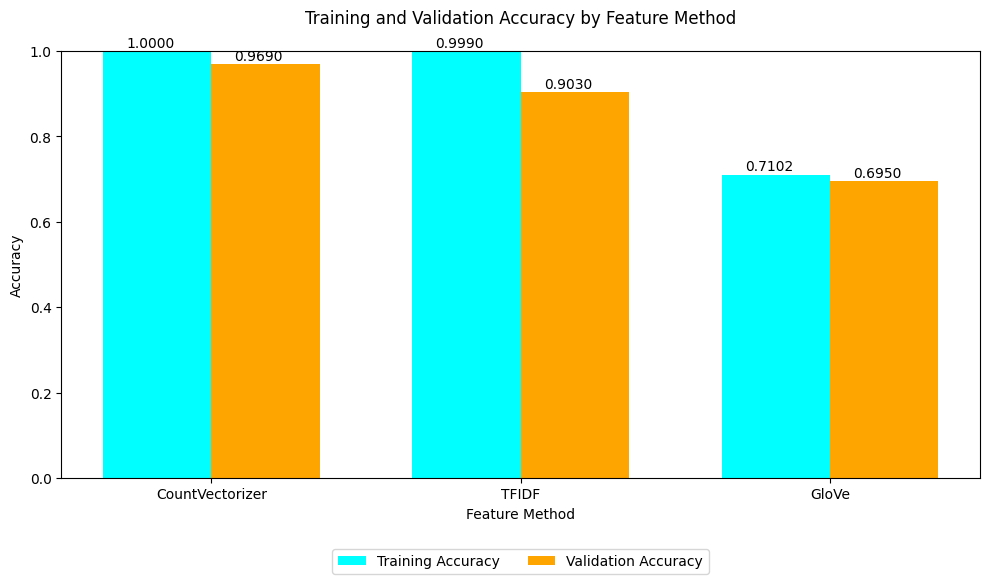

In [11]:
import pandas as pd
from tabulate import tabulate


# Define a dictionary to hold results for each feature extraction method
results = {
    "Feature Method": ["CountVectorizer", "TFIDF", "GloVe"],
    "Training Accuracy Mean": [],
    "Training Accuracy StdDev": [],
    "Validation Accuracy Mean": [],
    "Validation Accuracy StdDev": []
}

# Append each method's accuracies and standard deviations to the dictionary
results["Training Accuracy Mean"].append(cv_results['Training Accuracy Mean'])
results["Training Accuracy StdDev"].append(cv_results['Training Accuracy StdDev'])
results["Validation Accuracy Mean"].append(cv_results['Validation Accuracy Mean'])
results["Validation Accuracy StdDev"].append(cv_results['Validation Accuracy StdDev'])

results["Training Accuracy Mean"].append(tfidf_results['Training Accuracy Mean'])
results["Training Accuracy StdDev"].append(tfidf_results['Training Accuracy StdDev'])
results["Validation Accuracy Mean"].append(tfidf_results['Validation Accuracy Mean'])
results["Validation Accuracy StdDev"].append(tfidf_results['Validation Accuracy StdDev'])

results["Training Accuracy Mean"].append(glove_results['Training Accuracy Mean'])
results["Training Accuracy StdDev"].append(glove_results['Training Accuracy StdDev'])
results["Validation Accuracy Mean"].append(glove_results['Validation Accuracy Mean'])
results["Validation Accuracy StdDev"].append(glove_results['Validation Accuracy StdDev'])


compiled_results_df = pd.DataFrame(results).round(4)
print(tabulate(compiled_results_df, headers='keys', tablefmt='pretty'))

plot_accuracy_bar_chart(
    compiled_results_df,
    title="Training and Validation Accuracy by Feature Method",
    xlabel="Feature Method",
    ylabel="Accuracy"
)

## Exploring the Neural Network Models with Pre-Processed Training Data
Step 2 of the assignment explores how different hyperparameters affect the model's performance. Here, we explore the following:
- learning rates
- optimizers

### 5-Fold Cross Validation with Respect to Learning Rates
Model Configuration
- Input size: Based on feature dimensions
- Hidden layers: 2 layers with 128 neurons each
- Output size: 5 (number of classes)
- Optimizer: Adam
- Loss function: CrossEntropyLoss
- Epochs: 20
- Cross validation: 5 folds

Learning Rate Values Tested <br>
`learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]`

#### CountVectorizer

+----+---------------+------------------------+--------------------------+--------------------------+----------------------------+
|    | Learning Rate | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+----+---------------+------------------------+--------------------------+--------------------------+----------------------------+
| 0  |    0.0001     |         0.9625         |          0.0452          |          0.865           |           0.0466           |
| 1  |    0.0002     |         0.997          |          0.0034          |          0.931           |           0.0206           |
| 2  |    0.0003     |         0.9995         |          0.0006          |          0.954           |           0.0124           |
| 3  |    0.0004     |          1.0           |           0.0            |          0.968           |           0.015            |
| 4  |    0.0005     |          1.0           |           0.0            |         

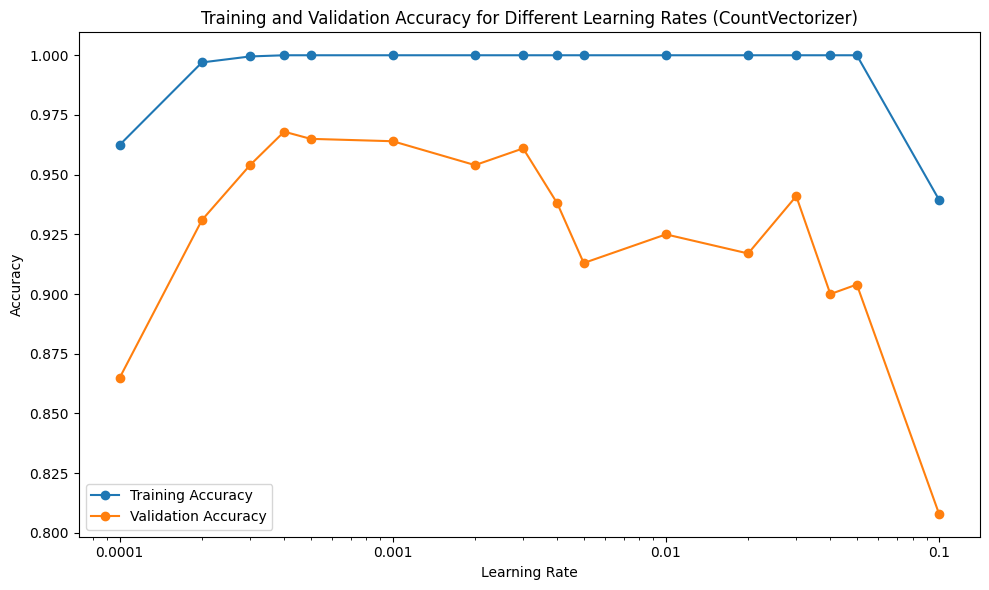

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply preprocessing and set up tensors manually
apply_preprocessing(df, method='countVec')
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['Category'].factorize()[0]

# Convert data to PyTorch tensors
X_tensor_cv = torch.tensor(X, dtype=torch.float32)
y_tensor_cv = torch.tensor(y, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_cv = X_tensor_cv.to(device)
y_tensor_cv = y_tensor_cv.to(device)

# Parameters
input_size = X_tensor_cv.shape[1]
hidden_size = 128
num_classes = 5
epochs = 20
learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

cv_results = lr_cross_validation(X_tensor_cv, y_tensor_cv, input_size, hidden_size, num_classes, kf, epochs, learning_rates, criterion, optimizer_class, device)

print(tabulate(cv_results, headers='keys', tablefmt='pretty'))

# Extract parameter values and accuracies from the results DataFrame
learning_rates = cv_results["Learning Rate"].tolist()
train_accuracies = cv_results["Training Accuracy Mean"].tolist()
val_accuracies = cv_results["Validation Accuracy Mean"].tolist()

# Plot the line chart for training and validation accuracy with respect to different learning rates
plot_accuracy_line_chart(
    param_values=learning_rates,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    param_name="Learning Rate",
    title="Training and Validation Accuracy for Different Learning Rates (CountVectorizer)"
)

#### TFIDF

+----+---------------+------------------------+--------------------------+--------------------------+----------------------------+
|    | Learning Rate | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+----+---------------+------------------------+--------------------------+--------------------------+----------------------------+
| 0  |    0.0001     |         0.2995         |          0.1079          |          0.268           |           0.0963           |
| 1  |    0.0002     |         0.4317         |          0.1202          |          0.351           |           0.0987           |
| 2  |    0.0003     |         0.6377         |          0.2083          |          0.497           |           0.1483           |
| 3  |    0.0004     |         0.8245         |          0.1088          |          0.595           |           0.0957           |
| 4  |    0.0005     |         0.8987         |          0.0722          |         

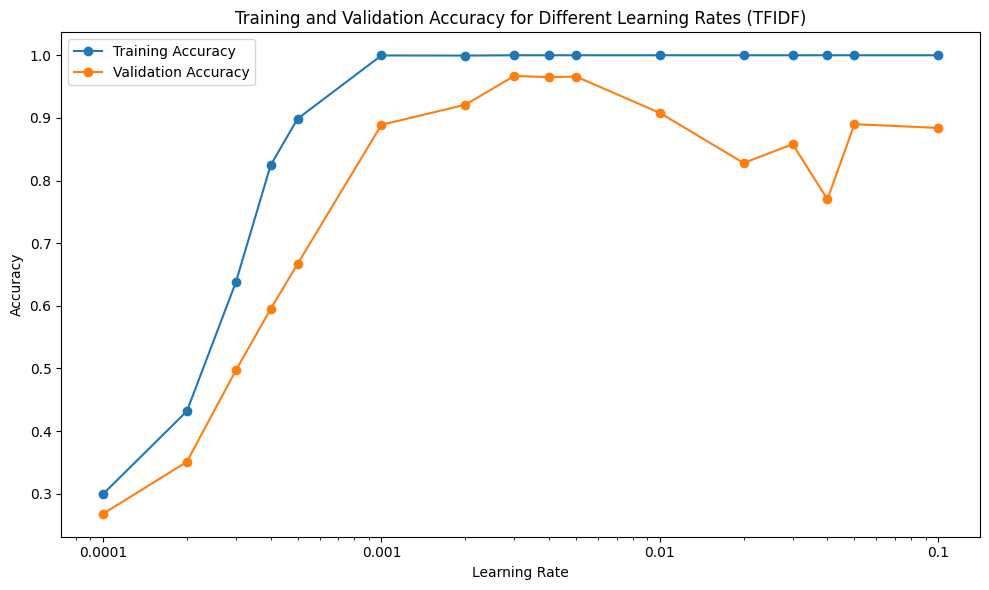

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply TF-IDF Vectorizer
apply_preprocessing(df, method='tfidf')
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text']).toarray()
y = df['Category'].factorize()[0]

# Convert data to PyTorch tensors
X_tensor_tfidf = torch.tensor(X_tfidf, dtype=torch.float32)
y_tensor_tfidf = torch.tensor(y, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_tfidf = X_tensor_tfidf.to(device)
y_tensor_tfidf = y_tensor_tfidf.to(device)

# Parameters
input_size = X_tensor_tfidf.shape[1]
hidden_size = 128
num_classes = 5
epochs = 20
learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

tfidf_results = lr_cross_validation(X_tensor_tfidf, y_tensor_tfidf, input_size, hidden_size, num_classes, kf, epochs, learning_rates, criterion, optimizer_class, device)

print(tabulate(tfidf_results, headers="keys", tablefmt="pretty"))


# Extract parameter values and accuracies from the results DataFrame
learning_rates = tfidf_results["Learning Rate"].tolist()
train_accuracies = tfidf_results["Training Accuracy Mean"].tolist()
val_accuracies = tfidf_results["Validation Accuracy Mean"].tolist()

# Plot the line chart for training and validation accuracy with respect to different learning rates
plot_accuracy_line_chart(
    param_values=learning_rates,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    param_name="Learning Rate",
    title="Training and Validation Accuracy for Different Learning Rates (TFIDF)"
)

#### GloVe

+----+---------------+------------------------+--------------------------+--------------------------+----------------------------+
|    | Learning Rate | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+----+---------------+------------------------+--------------------------+--------------------------+----------------------------+
| 0  |    0.0001     |         0.3622         |          0.1422          |          0.353           |            0.14            |
| 1  |    0.0002     |          0.5           |          0.074           |          0.514           |           0.0751           |
| 2  |    0.0003     |         0.526          |          0.0497          |          0.517           |           0.0641           |
| 3  |    0.0004     |         0.495          |          0.0676          |          0.498           |           0.0715           |
| 4  |    0.0005     |         0.506          |          0.0482          |         

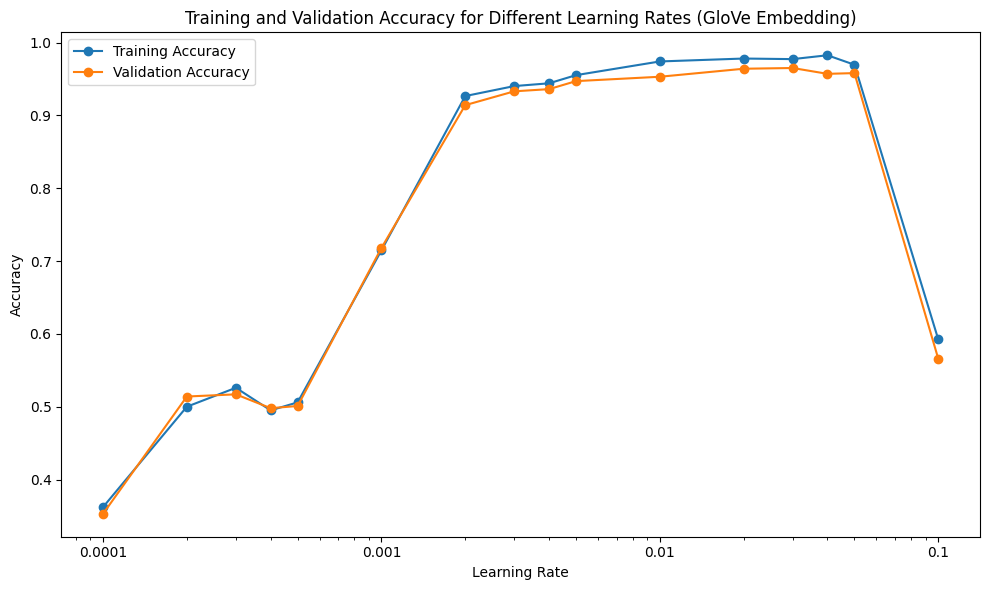

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply preprocessing with word embeddings
apply_preprocessing(df, method='glove')
X_glove = np.array(df['processed_text'].tolist())

# Convert data to PyTorch tensors
X_tensor_glove = torch.tensor(X_glove, dtype=torch.float32)
y_tensor_glove = torch.tensor(df['Category'].factorize()[0], dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_glove = X_tensor_glove.to(device)
y_tensor_glove = y_tensor_glove.to(device)

# Parameters
input_size = X_tensor_glove.shape[1]  # should match GloVe embedding size
hidden_size = 128
num_classes = 5
epochs = 20
learning_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

glove_results = lr_cross_validation(X_tensor_glove, y_tensor_glove, input_size, hidden_size, num_classes, kf, epochs, learning_rates, criterion, optimizer_class, device)

print(tabulate(glove_results, headers="keys", tablefmt="pretty"))


# Extract parameter values and accuracies from the results DataFrame
learning_rates = glove_results["Learning Rate"].tolist()
train_accuracies = glove_results["Training Accuracy Mean"].tolist()
val_accuracies = glove_results["Validation Accuracy Mean"].tolist()

# Plot the line chart for training and validation accuracy with respect to different learning rates
plot_accuracy_line_chart(
    param_values=learning_rates,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    param_name="Learning Rate",
    title="Training and Validation Accuracy for Different Learning Rates (GloVe Embedding)"
)

### 5-Fold Cross Validation with Respect to Optimizers
Model Configuration
- Input size: Based on feature dimensions
- Hidden layers: 2 layers with 128 neurons each
- Output size: 5 (number of classes)
- Learning rate: 0.001
- Loss function: CrossEntropyLoss
- Epochs: 20
- Cross validation: 5 folds

Optimizers Tested <br>
`optimizers = [optim.Adam, optim.SGD, optim.RMSprop, optim.AdamW]`

#### CountVectorizer

+---+-----------+------------------------+--------------------------+--------------------------+----------------------------+
|   | Optimizer | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+---+-----------+------------------------+--------------------------+--------------------------+----------------------------+
| 0 |   Adam    |          1.0           |           0.0            |          0.962           |           0.0136           |
| 1 |    SGD    |         0.191          |          0.0123          |          0.193           |           0.0316           |
| 2 |  RMSprop  |          1.0           |           0.0            |          0.958           |           0.0098           |
| 3 |   AdamW   |          1.0           |           0.0            |           0.96           |           0.0095           |
+---+-----------+------------------------+--------------------------+--------------------------+----------------------

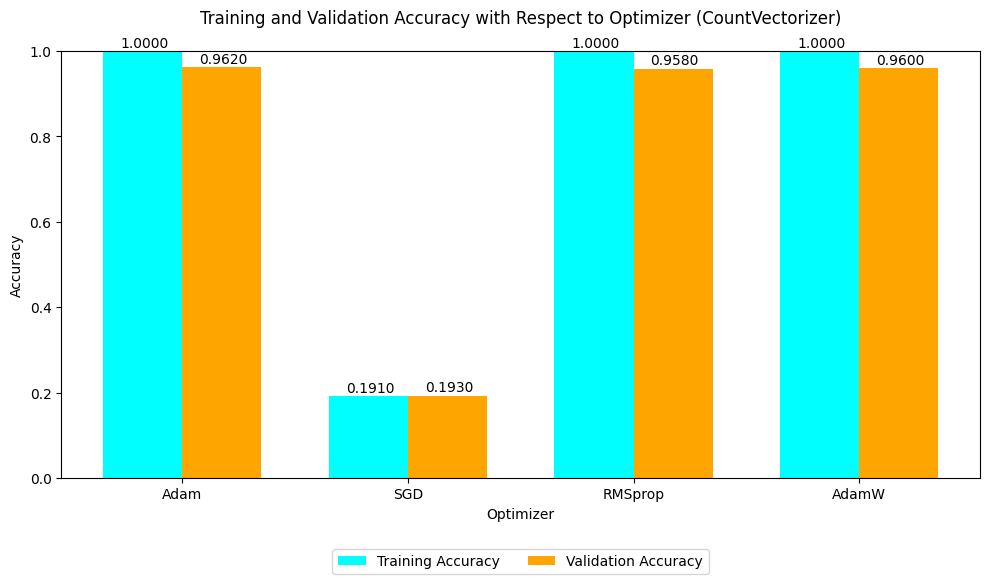

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply preprocessing and set up tensors manually
apply_preprocessing(df, method='countVec')
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['Category'].factorize()[0]

# Convert data to PyTorch tensors
X_tensor_cv = torch.tensor(X, dtype=torch.float32)
y_tensor_cv = torch.tensor(y, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_cv = X_tensor_cv.to(device)
y_tensor_cv = y_tensor_cv.to(device)

# Parameters
input_size = X_tensor_cv.shape[1]
hidden_size = 128
num_classes = 5
epochs = 20
learning_rate = 0.001  # Control the learning rate here
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam, optim.SGD, optim.RMSprop, optim.AdamW]

# Run cross-validation for each optimizer
cv_results = optimizer_cross_validation(X_tensor_cv, y_tensor_cv, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizers, device)

print(tabulate(cv_results, headers='keys', tablefmt='pretty'))


cv_results_bar = cv_results.copy()
cv_results_bar.rename(columns={"Optimizer": "Feature Method"}, inplace=True)

# Plot the bar chart for training and validation accuracy with respect to different optimizers
plot_accuracy_bar_chart(
    cv_results_bar,
    title="Training and Validation Accuracy with Respect to Optimizer (CountVectorizer)",
    xlabel="Optimizer",
    ylabel="Accuracy"
)


#### TFIDF

+---+-----------+------------------------+--------------------------+--------------------------+----------------------------+
|   | Optimizer | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+---+-----------+------------------------+--------------------------+--------------------------+----------------------------+
| 0 |   Adam    |          1.0           |           0.0            |          0.964           |           0.0097           |
| 1 |    SGD    |         0.2125         |          0.0193          |          0.211           |           0.0338           |
| 2 |  RMSprop  |          1.0           |           0.0            |          0.957           |           0.0112           |
| 3 |   AdamW   |          1.0           |           0.0            |          0.965           |           0.011            |
+---+-----------+------------------------+--------------------------+--------------------------+----------------------

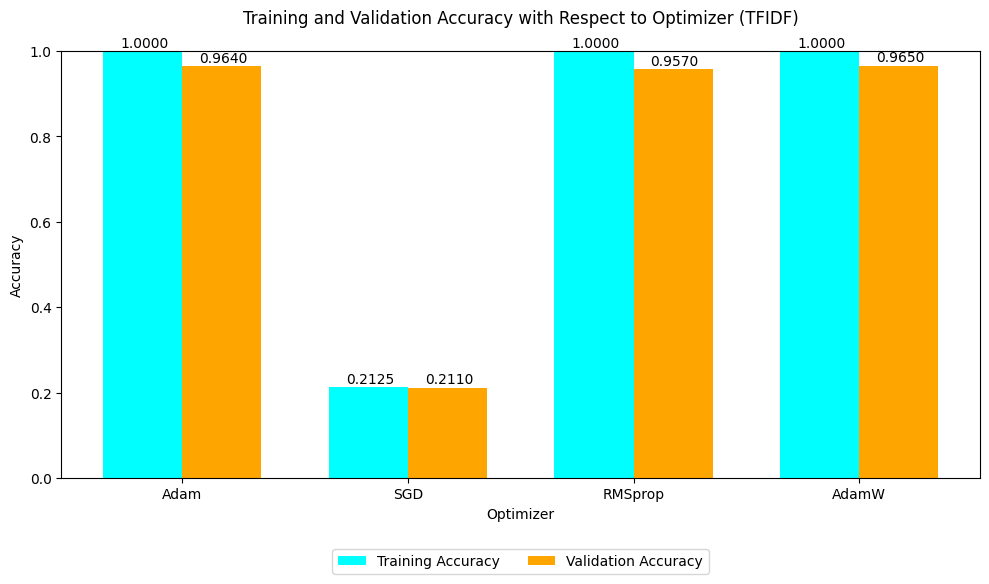

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from tabulate import tabulate

# Apply TF-IDF Vectorizer
apply_preprocessing(df, method='tfidf')
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text']).toarray()
y = df['Category'].factorize()[0]

# Convert data to PyTorch tensors
X_tensor_tfidf = torch.tensor(X_tfidf, dtype=torch.float32)
y_tensor_tfidf = torch.tensor(y, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_tfidf = X_tensor_tfidf.to(device)
y_tensor_tfidf = y_tensor_tfidf.to(device)

# Parameters
input_size = X_tensor_cv.shape[1]
hidden_size = 128
num_classes = 5
epochs = 20
learning_rate = 0.001  # Control the learning rate here
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam, optim.SGD, optim.RMSprop, optim.AdamW]

# Run cross-validation for each optimizer
tfidf_results = optimizer_cross_validation(X_tensor_cv, y_tensor_cv, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizers, device)

print(tabulate(tfidf_results, headers='keys', tablefmt='pretty'))


tfidf_results_bar = tfidf_results.copy()
tfidf_results_bar.rename(columns={"Optimizer": "Feature Method"}, inplace=True)

# Plot the bar chart for training and validation accuracy with respect to different optimizers
plot_accuracy_bar_chart(
    tfidf_results_bar,
    title="Training and Validation Accuracy with Respect to Optimizer (TFIDF)",
    xlabel="Optimizer",
    ylabel="Accuracy"
)

#### GloVe

+---+-----------+------------------------+--------------------------+--------------------------+----------------------------+
|   | Optimizer | Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+---+-----------+------------------------+--------------------------+--------------------------+----------------------------+
| 0 |   Adam    |          1.0           |           0.0            |          0.963           |           0.0075           |
| 1 |    SGD    |         0.183          |          0.0103          |          0.173           |           0.0244           |
| 2 |  RMSprop  |          1.0           |           0.0            |          0.965           |           0.011            |
| 3 |   AdamW   |          1.0           |           0.0            |          0.964           |           0.0124           |
+---+-----------+------------------------+--------------------------+--------------------------+----------------------

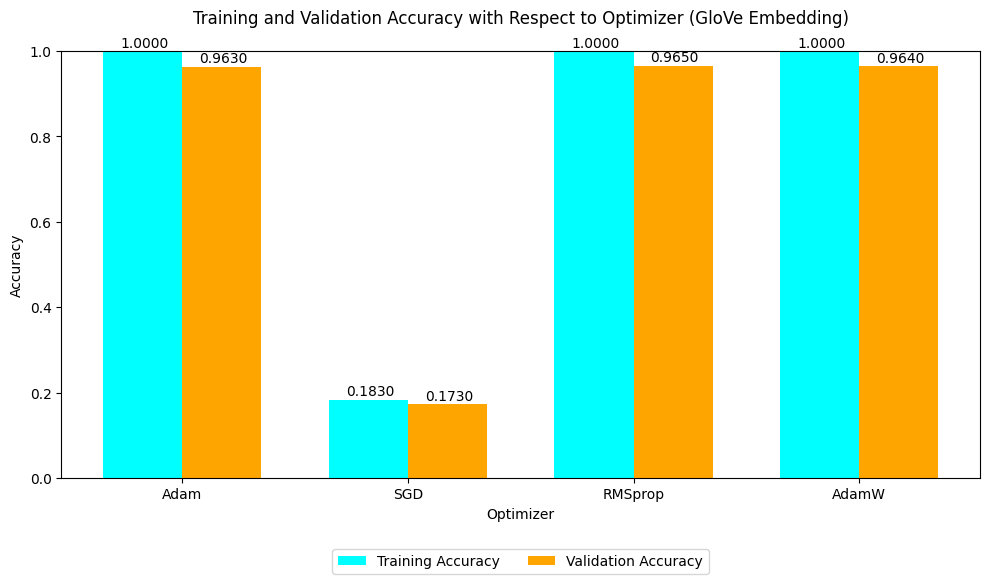

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tabulate import tabulate


# Apply preprocessing with word embeddings
apply_preprocessing(df, method='glove')
X_glove = np.array(df['processed_text'].tolist())

# Convert data to PyTorch tensors
X_tensor_glove = torch.tensor(X_glove, dtype=torch.float32)
y_tensor_glove = torch.tensor(df['Category'].factorize()[0], dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_glove = X_tensor_glove.to(device)
y_tensor_glove = y_tensor_glove.to(device)

# Parameters
input_size = X_tensor_cv.shape[1]
hidden_size = 128
num_classes = 5
epochs = 20
learning_rate = 0.001  # Control the learning rate here
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.Adam, optim.SGD, optim.RMSprop, optim.AdamW]

# Run cross-validation for each optimizer
glove_results = optimizer_cross_validation(X_tensor_cv, y_tensor_cv, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizers, device)

print(tabulate(glove_results, headers='keys', tablefmt='pretty'))


glove_results_bar = glove_results.copy()
glove_results_bar.rename(columns={"Optimizer": "Feature Method"}, inplace=True)

# Plot the bar chart for training and validation accuracy with respect to different optimizers
plot_accuracy_bar_chart(
    glove_results_bar,
    title="Training and Validation Accuracy with Respect to Optimizer (GloVe Embedding)",
    xlabel="Optimizer",
    ylabel="Accuracy"
)

## Model Inference on Test Data
Step 3 of the assignment.
- Performance optimization for maximum accuracy
- Test data prediction using best performing model

### Finding the Best Classifier and Feature Method

Based on the previous tests, the results show that GloVe embedding is the best feature to work with. The training and validation accuracies are very close to each other, meaning that it has lower likelihood of overfitting.

#### Random Forest classifier with GloVe embeddings

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from tabulate import tabulate


# Stack the embeddings into a 2D array (from a list of arrays)
apply_preprocessing(df, method='glove')
X = np.stack(df['processed_text'].values)


# Labels (target variable)
Y = df['Category']

# Splitting the training data (80% training, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from tabulate import tabulate

# Defining parameters to test
n_estimators = 300
max_features = 'sqrt'
criterion = 'gini'
max_depth = None
min_samples_split = 2
min_samples_leaf = 2
bootstrap = False

# Perform cross-validation
rf_clf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    criterion=criterion,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

# Initialize lists to store results
train_accuracies = []
val_accuracies = []
train_std = []
val_std = []


# Perform cross-validation and capture training and validation scores
train_scores = cross_val_score(rf_clf, X_train, Y_train, cv=5, scoring='accuracy')
val_scores = cross_val_score(rf_clf, X_val, Y_val, cv=5, scoring='accuracy')

# Store the mean accuracy and standard deviation
train_accuracies.append(np.mean(train_scores))
val_accuracies.append(np.mean(val_scores))
train_std.append(np.std(train_scores))
val_std.append(np.std(val_scores))

# Pandas DataFrame to store and display the results
results_df = pd.DataFrame({
    'n_estimators': [n_estimators],
    'max_features': [max_features],
    'criterion': [criterion],
    'max_depth': [max_depth],
    'min_samples_split': [min_samples_split],
    'min_samples_leaf': [min_samples_leaf],
    'bootstrap': [bootstrap],
    'Training Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Training Std': train_std,
    'Validation Std': val_std
})

# Display the results in tabulation format
print(tabulate(results_df, headers='keys', tablefmt='grid'))

+----+----------------+----------------+-------------+-------------+---------------------+--------------------+-------------+---------------------+-----------------------+----------------+------------------+
|    |   n_estimators | max_features   | criterion   | max_depth   |   min_samples_split |   min_samples_leaf | bootstrap   |   Training Accuracy |   Validation Accuracy |   Training Std |   Validation Std |
+====+================+================+=============+=============+=====================+====================+=============+=====================+=======================+================+==================+
|  0 |            300 | sqrt           | gini        |             |                   2 |                  2 | False       |             0.95375 |                 0.945 |     0.00637377 |             0.04 |
+----+----------------+----------------+-------------+-------------+---------------------+--------------------+-------------+---------------------+---------------------

#### Neural Network with GloVe embeddings

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tabulate import tabulate

# Apply preprocessing with word embeddings
apply_preprocessing(df, method='glove')
X_glove = np.array(df['processed_text'].tolist())

# Convert data to PyTorch tensors
X_tensor_glove = torch.tensor(X_glove, dtype=torch.float32)
y_tensor_glove = torch.tensor(df['Category'].factorize()[0], dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_glove = X_tensor_glove.to(device)
y_tensor_glove = y_tensor_glove.to(device)

# Parameters
input_size = X_tensor_glove.shape[1]  # should match GloVe embedding size
hidden_size = 128
num_classes = 5
epochs = 100
learning_rate = 0.02
kf = KFold(n_splits=5)
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam

glove_results = train_evaluate_model(X_tensor_glove, y_tensor_glove, input_size, hidden_size, num_classes, kf, epochs, learning_rate, criterion, optimizer_class, device)

print(tabulate([glove_results], headers="keys", tablefmt="pretty"))

+------------------------+--------------------------+--------------------------+----------------------------+
| Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+------------------------+--------------------------+--------------------------+----------------------------+
|          1.0           |           0.0            |    0.9699999690055847    |   0.0031622746443853936    |
+------------------------+--------------------------+--------------------------+----------------------------+


### Tuning the Best Classifier and Feature Method

Based on our experiments, Neural Network with GloVe embeddings provided the highest generalization ability with balanced training and validation accuracies.
Here, we ncorporate multiple modern deep learning techniques:
- Shake-shake regularization for better generalization and preventing overfitting
- Residual connections to handle vanishing gradients in deep architecture
- Multi-path architecture (2 parallel paths) for ensemble-like benefits
- Batch normalization after each linear layer for stable training
- Progressive layer freezing
- Label smoothing
- Gradient clipping

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import KFold
from tabulate import tabulate


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


class ShakeShake(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        if self.training:
            alpha = torch.rand(x1.size(0), 1, device=x1.device)
            alpha = alpha.expand_as(x1)
            return alpha * x1 + (1 - alpha) * x2
        else:
            return 0.5 * x1 + 0.5 * x2

class ResidualBranch(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.4):
        super().__init__()
        self.branch = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.GELU(),  # Changed to GELU for better performance
            nn.BatchNorm1d(out_features),
            nn.Dropout(dropout_rate),
            nn.Linear(out_features, out_features),
            nn.GELU(),
            nn.BatchNorm1d(out_features),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.branch(x)

class AdvancedResBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.4):
        super().__init__()
        self.branch1 = ResidualBranch(in_features, out_features, dropout_rate)
        self.branch2 = ResidualBranch(in_features, out_features, dropout_rate)
        self.shake = ShakeShake()
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        shake = self.shake(x1, x2)
        return shake + self.shortcut(x)

class AdvancedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        # Initial layer with wider network
        self.input_block = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.GELU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5)
        )

        # Multiple parallel paths with residual connections
        self.path1 = nn.ModuleList([
            AdvancedResBlock(2048, 1024, 0.5),
            AdvancedResBlock(1024, 512, 0.4),
            AdvancedResBlock(512, 256, 0.3)
        ])

        self.path2 = nn.ModuleList([
            AdvancedResBlock(2048, 1024, 0.5),
            AdvancedResBlock(1024, 512, 0.4),
            AdvancedResBlock(512, 256, 0.3)
        ])

        self.shake = ShakeShake()

        # Output layers
        self.output = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.input_block(x)

        # Process through parallel paths
        x1 = x
        x2 = x

        for p1, p2 in zip(self.path1, self.path2):
            x1 = p1(x1)
            x2 = p2(x2)

        # Shake-shake regularization
        x = self.shake(x1, x2)

        return self.output(x)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

def train_advanced_model(X_tensor, y_tensor, input_size, num_classes, kf, device):
    training_accuracies = []
    validation_accuracies = []

    # Enhanced training parameters
    epochs = 200
    initial_lr = 0.001
    patience = 15
    max_grad_norm = 0.5

    for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]

        model = AdvancedNN(input_size, num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=0.02)
        criterion = LabelSmoothingLoss(num_classes, smoothing=0.1)

        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.01,
            steps_per_epoch=1,
            epochs=epochs,
            pct_start=0.3,
            div_factor=25.0,
            final_div_factor=1000.0
        )

        early_stopping = EarlyStopping(patience=patience, min_delta=0.0005)
        best_val_acc = 0

        # Progressive layer freezing
        freeze_epochs = [50, 75, 100]  # Epochs at which to freeze layers
        layers_to_freeze = [model.input_block, model.path1[0], model.path2[0]]

        for epoch in range(epochs):
            model.train()

            # Progressive freezing
            if epoch in freeze_epochs:
                layer_idx = freeze_epochs.index(epoch)
                if layer_idx < len(layers_to_freeze):
                    for param in layers_to_freeze[layer_idx].parameters():
                        param.requires_grad = False

            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                val_acc = (val_outputs.argmax(1) == y_val).float().mean().item()

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = model.state_dict()

            scheduler.step()
            early_stopping(val_loss.item())
            if early_stopping.early_stop:
                break

        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            train_acc = (model(X_train).argmax(1) == y_train).float().mean().item()
            val_acc = (model(X_val).argmax(1) == y_val).float().mean().item()
            training_accuracies.append(train_acc)
            validation_accuracies.append(val_acc)

        print(f"Fold {fold+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    results = {
        'Training Accuracy Mean': np.mean(training_accuracies),
        'Training Accuracy StdDev': np.std(training_accuracies),
        'Validation Accuracy Mean': np.mean(validation_accuracies),
        'Validation Accuracy StdDev': np.std(validation_accuracies)
    }

    return results, model



# Apply preprocessing with word embeddings
train_df = pd.read_csv('24_train_1.csv')
apply_preprocessing(train_df, method='glove')
X_glove = np.array(train_df['processed_text'].tolist())

# Convert data to PyTorch tensors
X_tensor_glove = torch.tensor(X_glove, dtype=torch.float32)
y_tensor_glove = torch.tensor(train_df['Category'].factorize()[0], dtype=torch.long)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor_glove = X_tensor_glove.to(device)
y_tensor_glove = y_tensor_glove.to(device)

# Run the training
results, best_model = train_advanced_model(
    X_tensor_glove,
    y_tensor_glove,
    input_size=X_tensor_glove.shape[1],
    num_classes=5,
    kf=KFold(n_splits=5, shuffle=True, random_state=42),
    device=device
)

print("\nFinal Results:")
print(tabulate([results], headers="keys", tablefmt="pretty"))

Fold 1: Train Acc = 1.0000, Val Acc = 0.9700
Fold 2: Train Acc = 1.0000, Val Acc = 0.9600
Fold 3: Train Acc = 1.0000, Val Acc = 0.9850
Fold 4: Train Acc = 1.0000, Val Acc = 0.9750
Fold 5: Train Acc = 1.0000, Val Acc = 0.9800

Final Results:
+------------------------+--------------------------+--------------------------+----------------------------+
| Training Accuracy Mean | Training Accuracy StdDev | Validation Accuracy Mean | Validation Accuracy StdDev |
+------------------------+--------------------------+--------------------------+----------------------------+
|          1.0           |           0.0            |    0.9739999651908875    |    0.00860231706322596     |
+------------------------+--------------------------+--------------------------+----------------------------+


### Predicting the labels for the testing data

In [21]:
import os
import pandas as pd
import numpy as np
import torch

# Define local path for test file
test_file_path = "news-test-1.csv"

# Check if file exists locally
if not os.path.exists(test_file_path):
    print(f"Error: {test_file_path} not found in the current directory.")
else:
    print(f"Loading {test_file_path}...")
    test_df = pd.read_csv(test_file_path)
    print("Test file loaded successfully!")
    print("\nFirst few rows of the test dataset:")
    print(test_df.head())

    # Preprocess test data using GloVe embeddings
    X_test_glove = np.array([preprocess_for_glove(text, glove_embeddings) for text in test_df['Text']])

    # Convert to tensor and move to device
    X_test_tensor = torch.tensor(X_test_glove, dtype=torch.float32).to(device)

    # During training, store the categories when you factorize
    categories = train_df['Category'].factorize()[1]

    # Make predictions
    best_model.eval()
    with torch.no_grad():
        test_outputs = best_model(X_test_tensor)
        predictions = test_outputs.argmax(1).cpu().numpy()

    # Map predictions back to labels
    predicted_labels = categories[predictions]

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'ArticleId': test_df['ArticleId'],
        'Category': predicted_labels
    })

    # Save predictions
    output_path = 'labels.csv'
    submission_df.to_csv(output_path, index=False, header=False)
    print(f"Predictions saved to {output_path}")
    

Loading news-test-1.csv...
Test file loaded successfully!

First few rows of the test dataset:
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
Predictions saved to labels.csv
